In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день: 
Будет дождь, если rainfall >=1

In [2]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
df.shape

(145460, 23)

Удалим столбцы

In [4]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [5]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

In [8]:
df[df['RainTomorrow']==0.0].count()

Rainfall        97103
Humidity3pm     97103
Pressure9am     97103
RainToday       97103
RainTomorrow    97103
dtype: int64

In [9]:
df[df['RainTomorrow']==1.0].count()

Rainfall        27586
Humidity3pm     27586
Pressure9am     27586
RainToday       27586
RainTomorrow    27586
dtype: int64

Классы несбалансированы

In [10]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [11]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


# NN

In [12]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)
    
    # torch.nn.init.xavier_uniform_(self.fc1.weight) 

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [13]:
criterion = nn.BCELoss()

In [14]:
device = torch.device( "cpu")

In [15]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [16]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [17]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
        
    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628505706787, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.5720736980438232, accuracy: 0.7959740161895752
    
epoch 200
    Test  set - loss: 0.5436038970947266, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333547592163086, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.5154790282249451, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.4807438552379608, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.46781161427497864, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.4557374119758606, accuracy: 0.784826397895813
    
epoch 800
    Test  set - loss: 0.44437211751937866, accuracy: 0.791202187538147
    
epoch 900
    Test  set - loss: 0.43355458974838257, accuracy: 0.798700749874115
    
epoch 1000
    Test  set - loss: 0.42411327362060547, accuracy: 0.810610294342041
    
epoch 1100
    Test  set - loss: 0.4170910120010376, acc

In [18]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [19]:
net = torch.load(MODEL_PATH)

In [20]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.84      0.82     24938



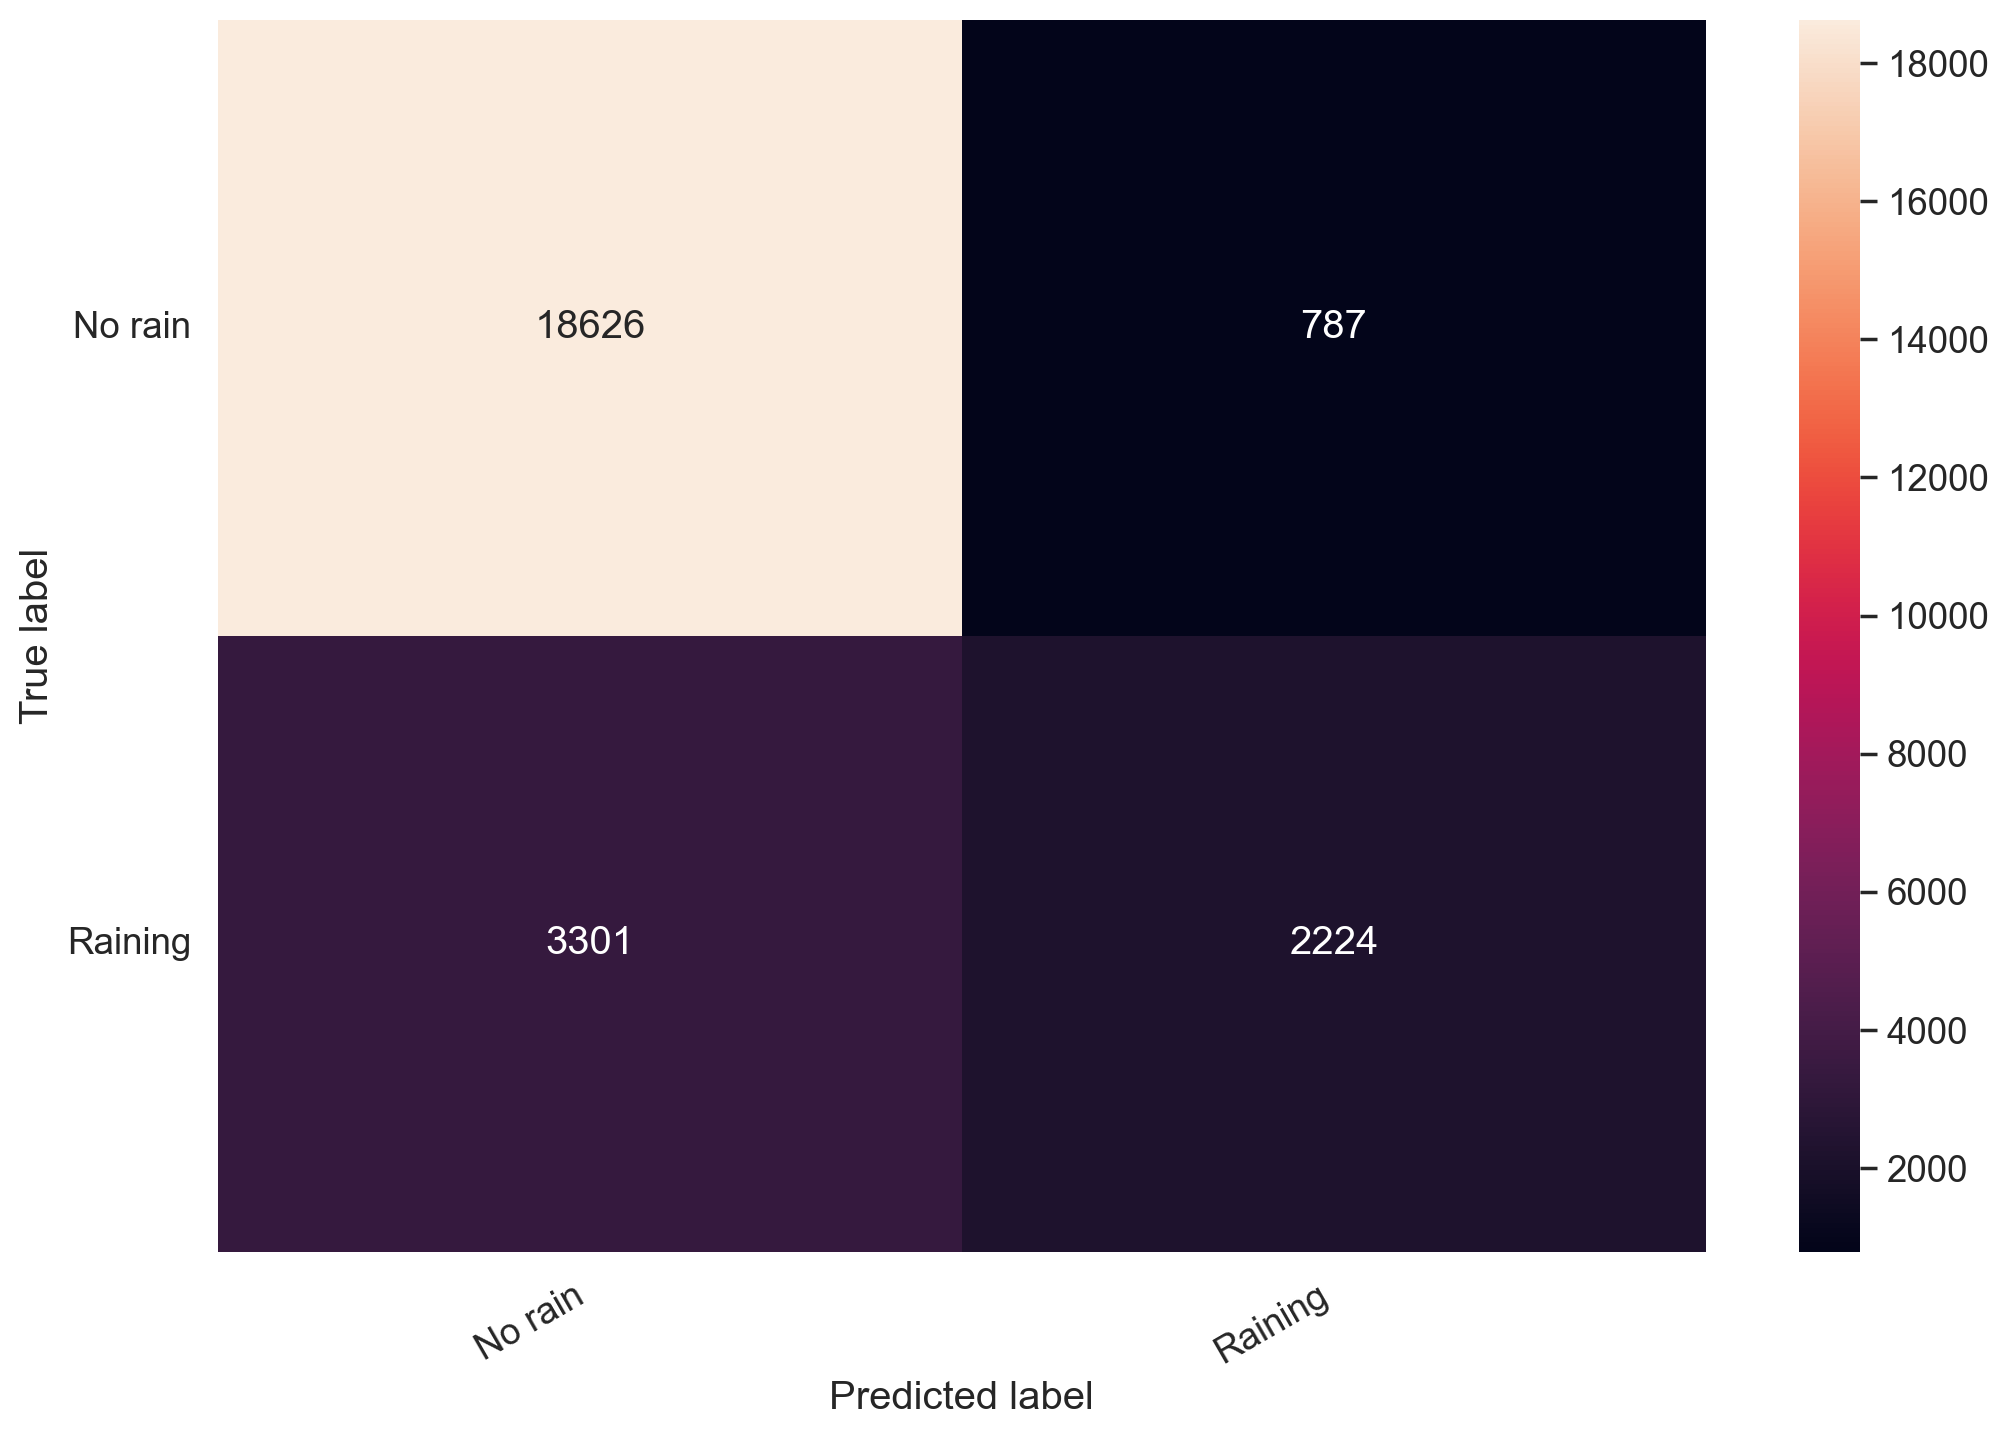

In [21]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

### 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate,  выберите оптимальное значение.


In [22]:
def compute_accuracy(y_true, y_pred):
    y_pred_rounded = torch.round(y_pred)
    correct = (y_pred_rounded == y_true).float().sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy

def train_and_evaluate(learning_rate):
    net = Net(4)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()

        train_loss = criterion(y_pred, y_train.float())

        train_loss.backward()

        optimizer.step()

        train_losses.append(train_loss.item())

        train_accuracy = compute_accuracy(y_train, y_pred)

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())
            test_accuracy = compute_accuracy(y_test, y_test_pred)
            print(f"Epoch {epoch}: Train Loss = {train_loss.item():.4f}, Test Loss = {test_loss.item():.4f}, Train Acc = {train_accuracy:.4f}, Test Acc = {test_accuracy:.4f}")


    return train_losses, test_losses

Обучение с lr: 0.0001
Epoch 0: Train Loss = 1.7984, Test Loss = 1.7902, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 100: Train Loss = 0.8740, Test Loss = 0.8647, Train Acc = 0.7789, Test Acc = 0.7785
Epoch 200: Train Loss = 0.4176, Test Loss = 0.4167, Train Acc = 0.8247, Test Acc = 0.8256
Epoch 300: Train Loss = 0.4156, Test Loss = 0.4149, Train Acc = 0.8291, Test Acc = 0.8294
Epoch 400: Train Loss = 0.4142, Test Loss = 0.4136, Train Acc = 0.8296, Test Acc = 0.8298
Epoch 500: Train Loss = 0.4130, Test Loss = 0.4123, Train Acc = 0.8301, Test Acc = 0.8307
Epoch 600: Train Loss = 0.4118, Test Loss = 0.4111, Train Acc = 0.8303, Test Acc = 0.8309
Epoch 700: Train Loss = 0.4106, Test Loss = 0.4100, Train Acc = 0.8308, Test Acc = 0.8315
Epoch 800: Train Loss = 0.4096, Test Loss = 0.4090, Train Acc = 0.8312, Test Acc = 0.8327
Epoch 900: Train Loss = 0.4086, Test Loss = 0.4080, Train Acc = 0.8318, Test Acc = 0.8329
Epoch 1000: Train Loss = 0.4077, Test Loss = 0.4072, Train Acc = 0.8318, Test Ac

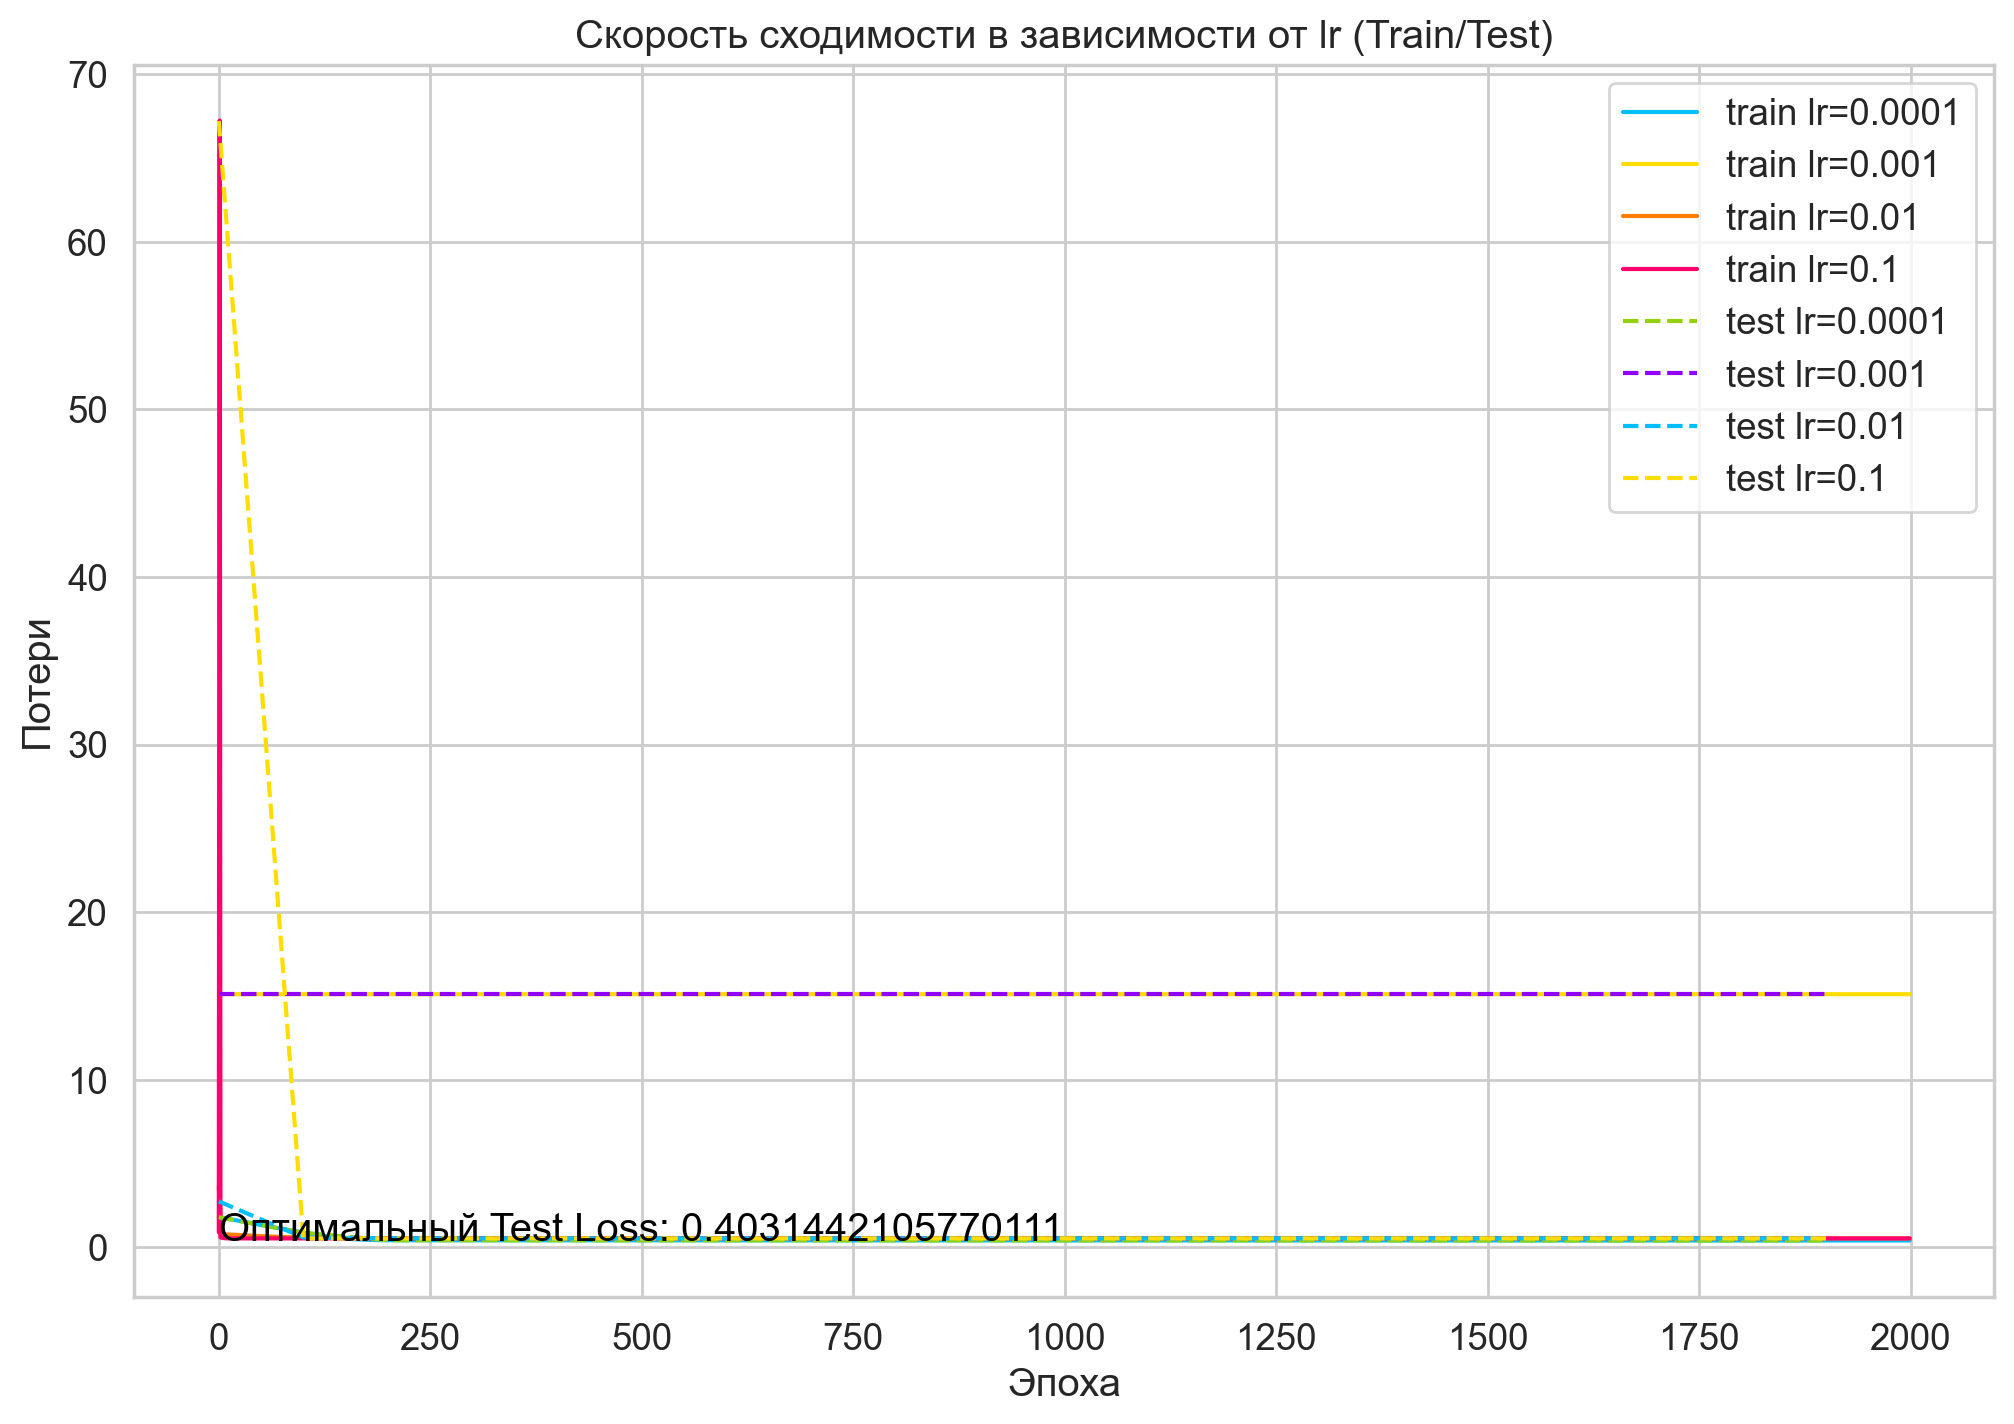

In [25]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
device = torch.device("cpu")
train_loss = {}
test_loss = {}
test_loss_sum = {}

# Процесс обучения для каждого learning_rate
for lr in learning_rates:
    print(f'Обучение с lr: {lr}')
    train_losses, test_losses = train_and_evaluate(lr)
    train_loss[lr] = train_losses
    test_loss[lr] = test_losses
    test_loss_sum[lr] = test_losses[-1]

optimal_lr = min(test_loss_sum, key=test_loss_sum.get)
print(f'Оптимальный lr: {optimal_lr}')

for lr, losses in train_loss.items():
    plt.plot(losses, label=f'train lr={lr}')

for lr, losses in test_loss.items():
    plt.plot(range(0, 2000, 100), losses, label=f'test lr={lr}', linestyle='--')

plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Скорость сходимости в зависимости от lr (Train/Test)')
plt.text(0, test_loss_sum[optimal_lr], f'Оптимальный Test Loss: {test_loss_sum[optimal_lr]}', color='black')
plt.legend()
plt.show()

### 2. Примените нормализацию данных. Исследуйте скорость сходимости.

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

Epoch 0: Train Loss = 0.6064, Test Loss = 0.6064, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 100: Train Loss = 0.6005, Test Loss = 0.6005, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 200: Train Loss = 0.5939, Test Loss = 0.5939, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 300: Train Loss = 0.5864, Test Loss = 0.5864, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 400: Train Loss = 0.5781, Test Loss = 0.5781, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 500: Train Loss = 0.5689, Test Loss = 0.5688, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 600: Train Loss = 0.5589, Test Loss = 0.5588, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 700: Train Loss = 0.5483, Test Loss = 0.5482, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 800: Train Loss = 0.5373, Test Loss = 0.5372, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 900: Train Loss = 0.5262, Test Loss = 0.5261, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 1000: Train Loss = 0.5153, Test Loss = 0.5151, Train Acc = 0.7788, Test Acc = 0.7785
Epoch 1100:

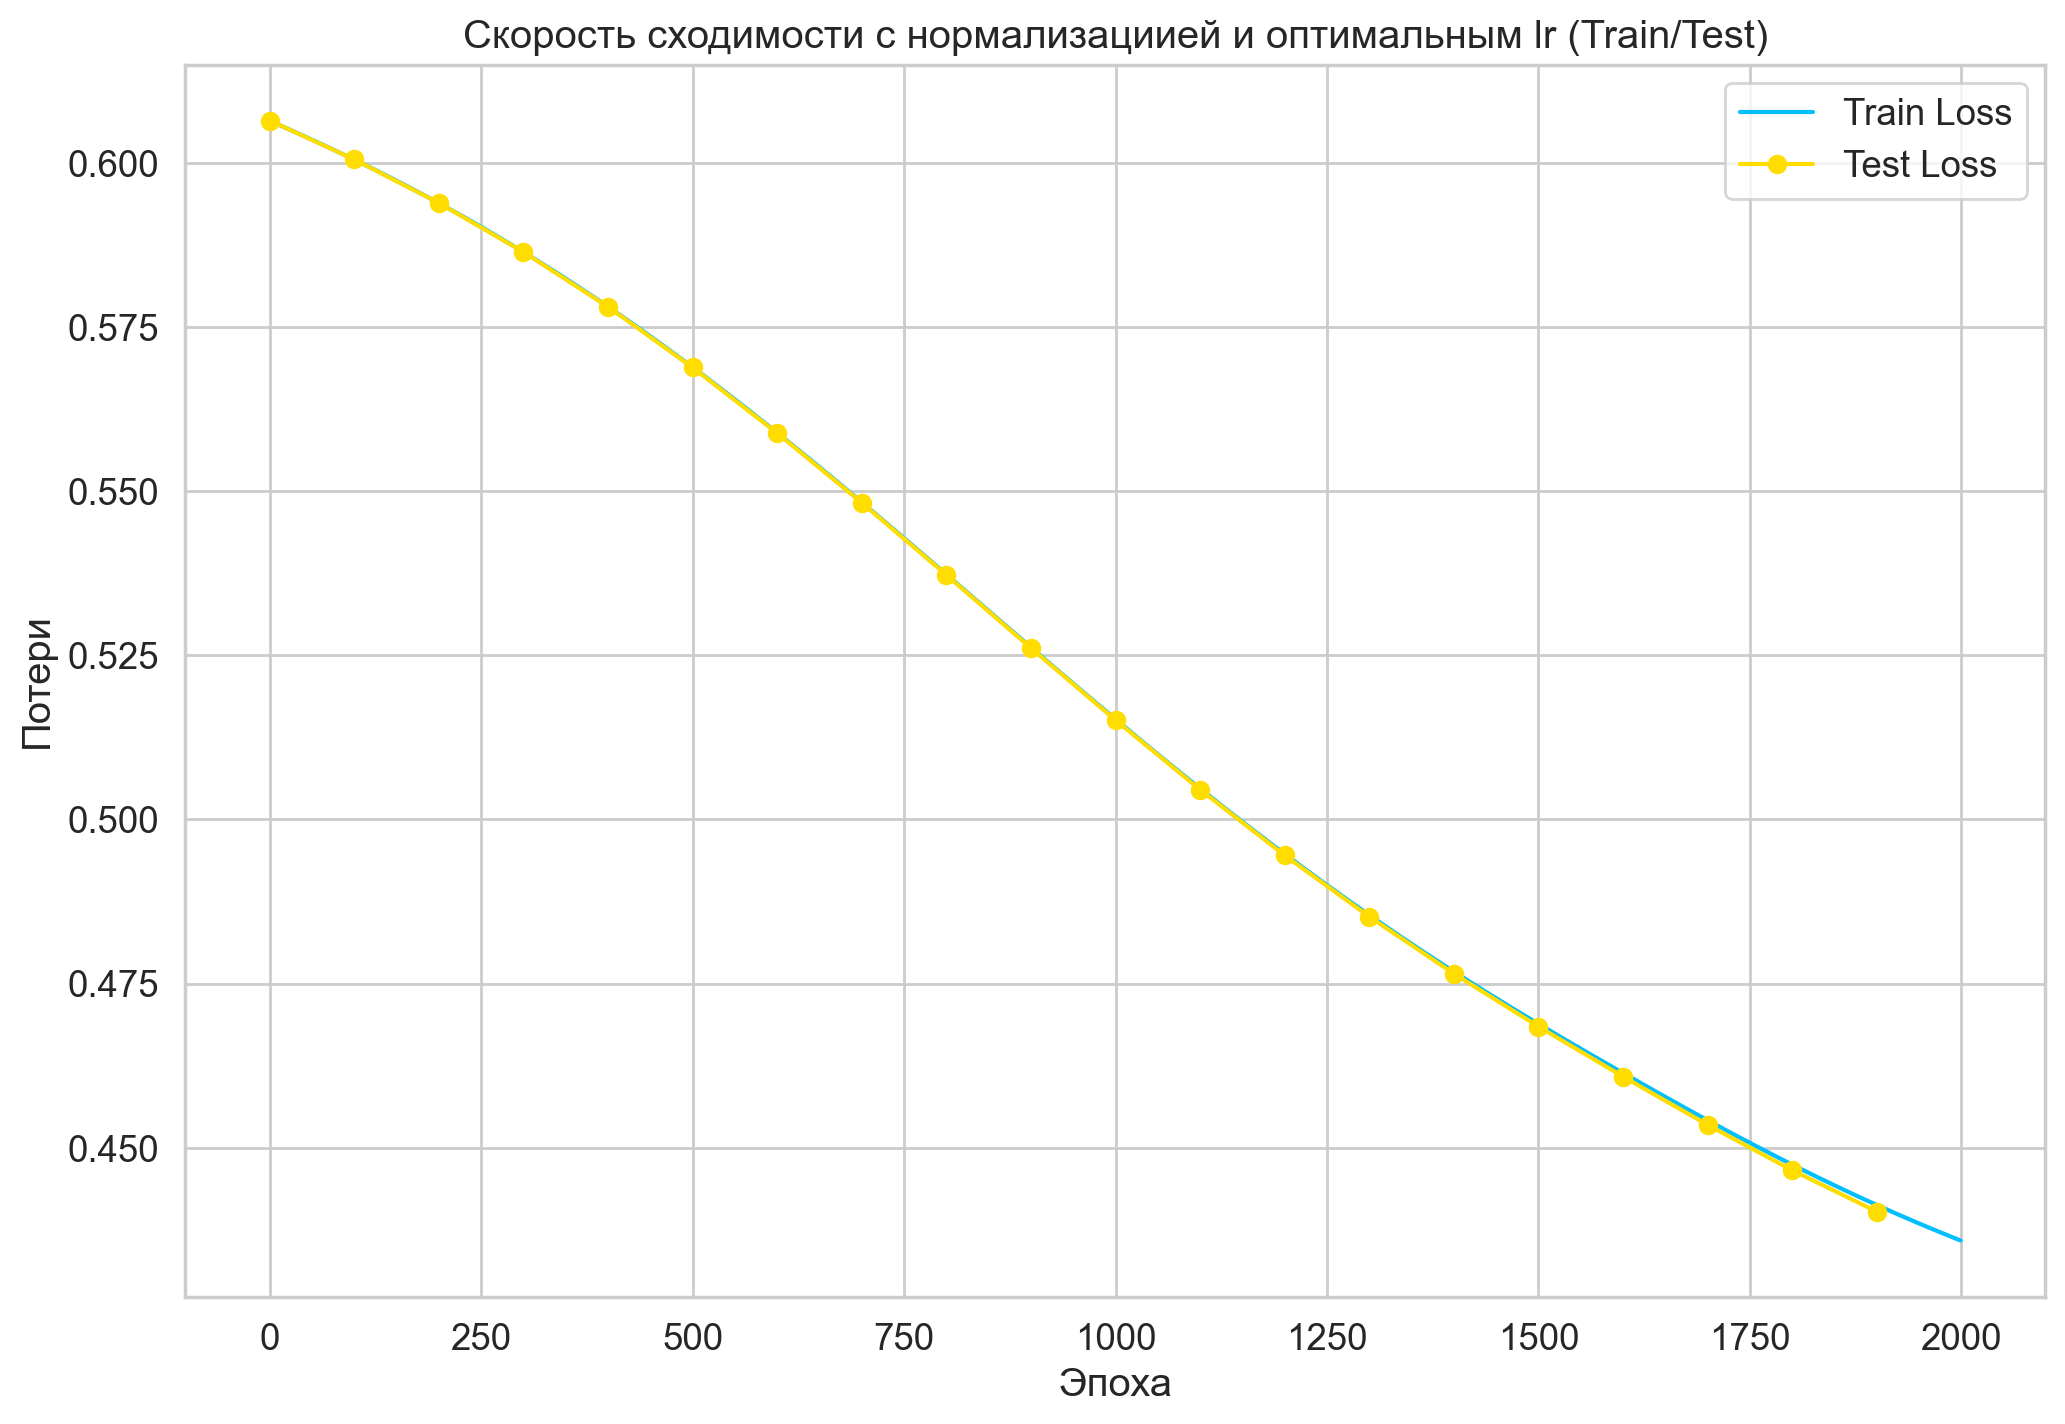

In [34]:
# обучение
train_losses, test_losses = train_and_evaluate(optimal_lr)

plt.plot(train_losses, label='Train Loss')
plt.plot(range(0, 2000, 100), test_losses, label='Test Loss', marker='o')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Скорость сходимости с нормализациией и оптимальным lr (Train/Test)')
plt.legend()
plt.show()

### 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления скрытого слоя, Удаления/добавления нейронов в каждом слое.


In [52]:
class MyNet(nn.Module):
    def __init__(self, n_features, n_neurons_per_layer, n_hidden_layers):
        super(MyNet, self).__init__()
        layers = []
        input_size = n_features

        # Добавление скрытых слоев
        for i in range(n_hidden_layers):
            layers.append(nn.Linear(input_size, n_neurons_per_layer))
            layers.append(nn.ReLU())
            input_size = n_neurons_per_layer

        layers.append(nn.Linear(input_size, 1))
        layers.append(nn.Sigmoid())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def train_and_evaluate_with_structure(n_neurons_per_layer, n_hidden_layers, learning_rate=0.1):
    net = MyNet(4, n_neurons_per_layer, n_hidden_layers)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()

        train_loss = criterion(y_pred, y_train.float())

        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses



Обучение с 0 скрытыми слоями и 2 нейронами в слое
Обучение с 1 скрытыми слоями и 4 нейронами в слое
Обучение с 2 скрытыми слоями и 8 нейронами в слое
Обучение с 3 скрытыми слоями и 16 нейронами в слое


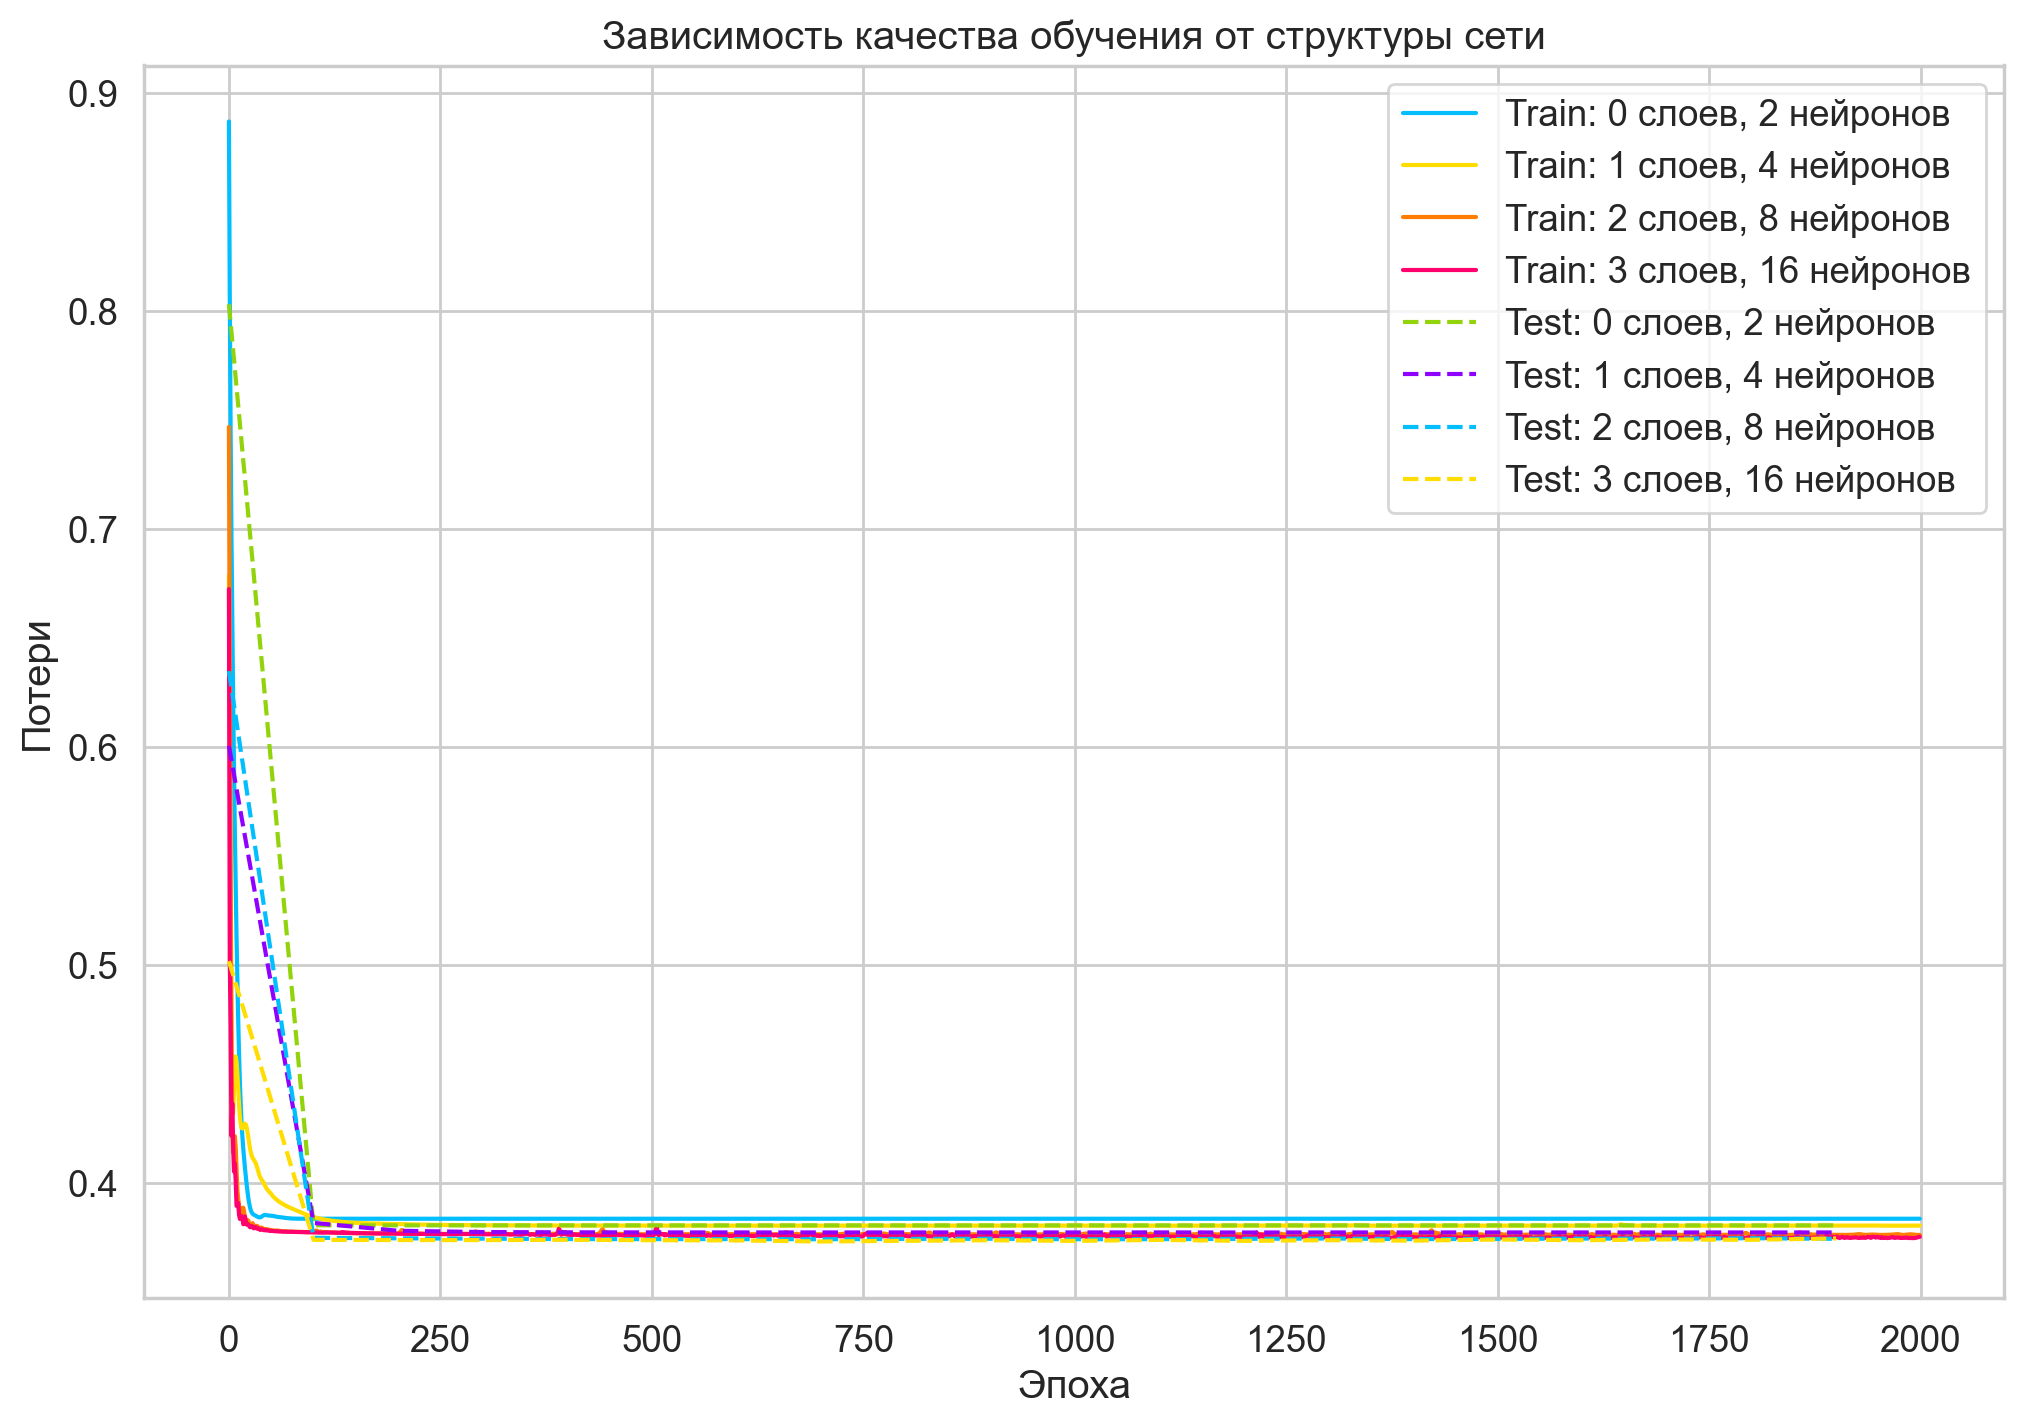

Конфигурация: 0 слоев, 2 нейронов -> Лучшее значение test_loss: 0.3803713619709015
Конфигурация: 1 слоев, 4 нейронов -> Лучшее значение test_loss: 0.37708720564842224
Конфигурация: 2 слоев, 8 нейронов -> Лучшее значение test_loss: 0.3739984929561615
Конфигурация: 3 слоев, 16 нейронов -> Лучшее значение test_loss: 0.37296393513679504


In [53]:
configurations = [
    (2, 0),
    (4, 1),
    (8, 2),
    (16, 3)
]

train_loss = {}
test_loss = {}

# Обучаем и собираем потери для каждой конфигурации
for n_neurons, n_layers in configurations:
    print(f'Обучение с {n_layers} скрытыми слоями и {n_neurons} нейронами в слое')
    train_losses, test_losses = train_and_evaluate_with_structure(n_neurons, n_layers)
    train_loss[(n_neurons, n_layers)] = train_losses
    test_loss[(n_neurons, n_layers)] = test_losses

for (n_neurons, n_layers), losses in train_loss.items():
    plt.plot(losses, label=f'Train: {n_layers} слоев, {n_neurons} нейронов')

for (n_neurons, n_layers), losses in test_loss.items():
    plt.plot(range(0, 2000, 100), losses, label=f'Test: {n_layers} слоев, {n_neurons} нейронов', linestyle='--')

plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Зависимость качества обучения от структуры сети')
plt.legend()
plt.show()

best_test_loss = {}

for (n_neurons, n_layers), losses in test_loss.items():
    best_loss = min(losses)
    best_test_loss[(n_neurons, n_layers)] = best_loss
    print(f"Конфигурация: {n_layers} слоев, {n_neurons} нейронов -> Лучшее значение test_loss: {best_loss}")


### 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях. 
 https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity


In [62]:
activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU(0.01),
    'ELU': nn.ELU()
}

class MyNet(nn.Module):
    def __init__(self, n_features, activation_fn):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(n_features, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

def train_and_evaluate_with_activation(activation_fn):
    net = MyNet(4, activation_fn)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.1)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()

        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

Обучение с функцией активации: ReLU
Обучение с функцией активации: Sigmoid
Обучение с функцией активации: Tanh
Обучение с функцией активации: LeakyReLU
Обучение с функцией активации: ELU


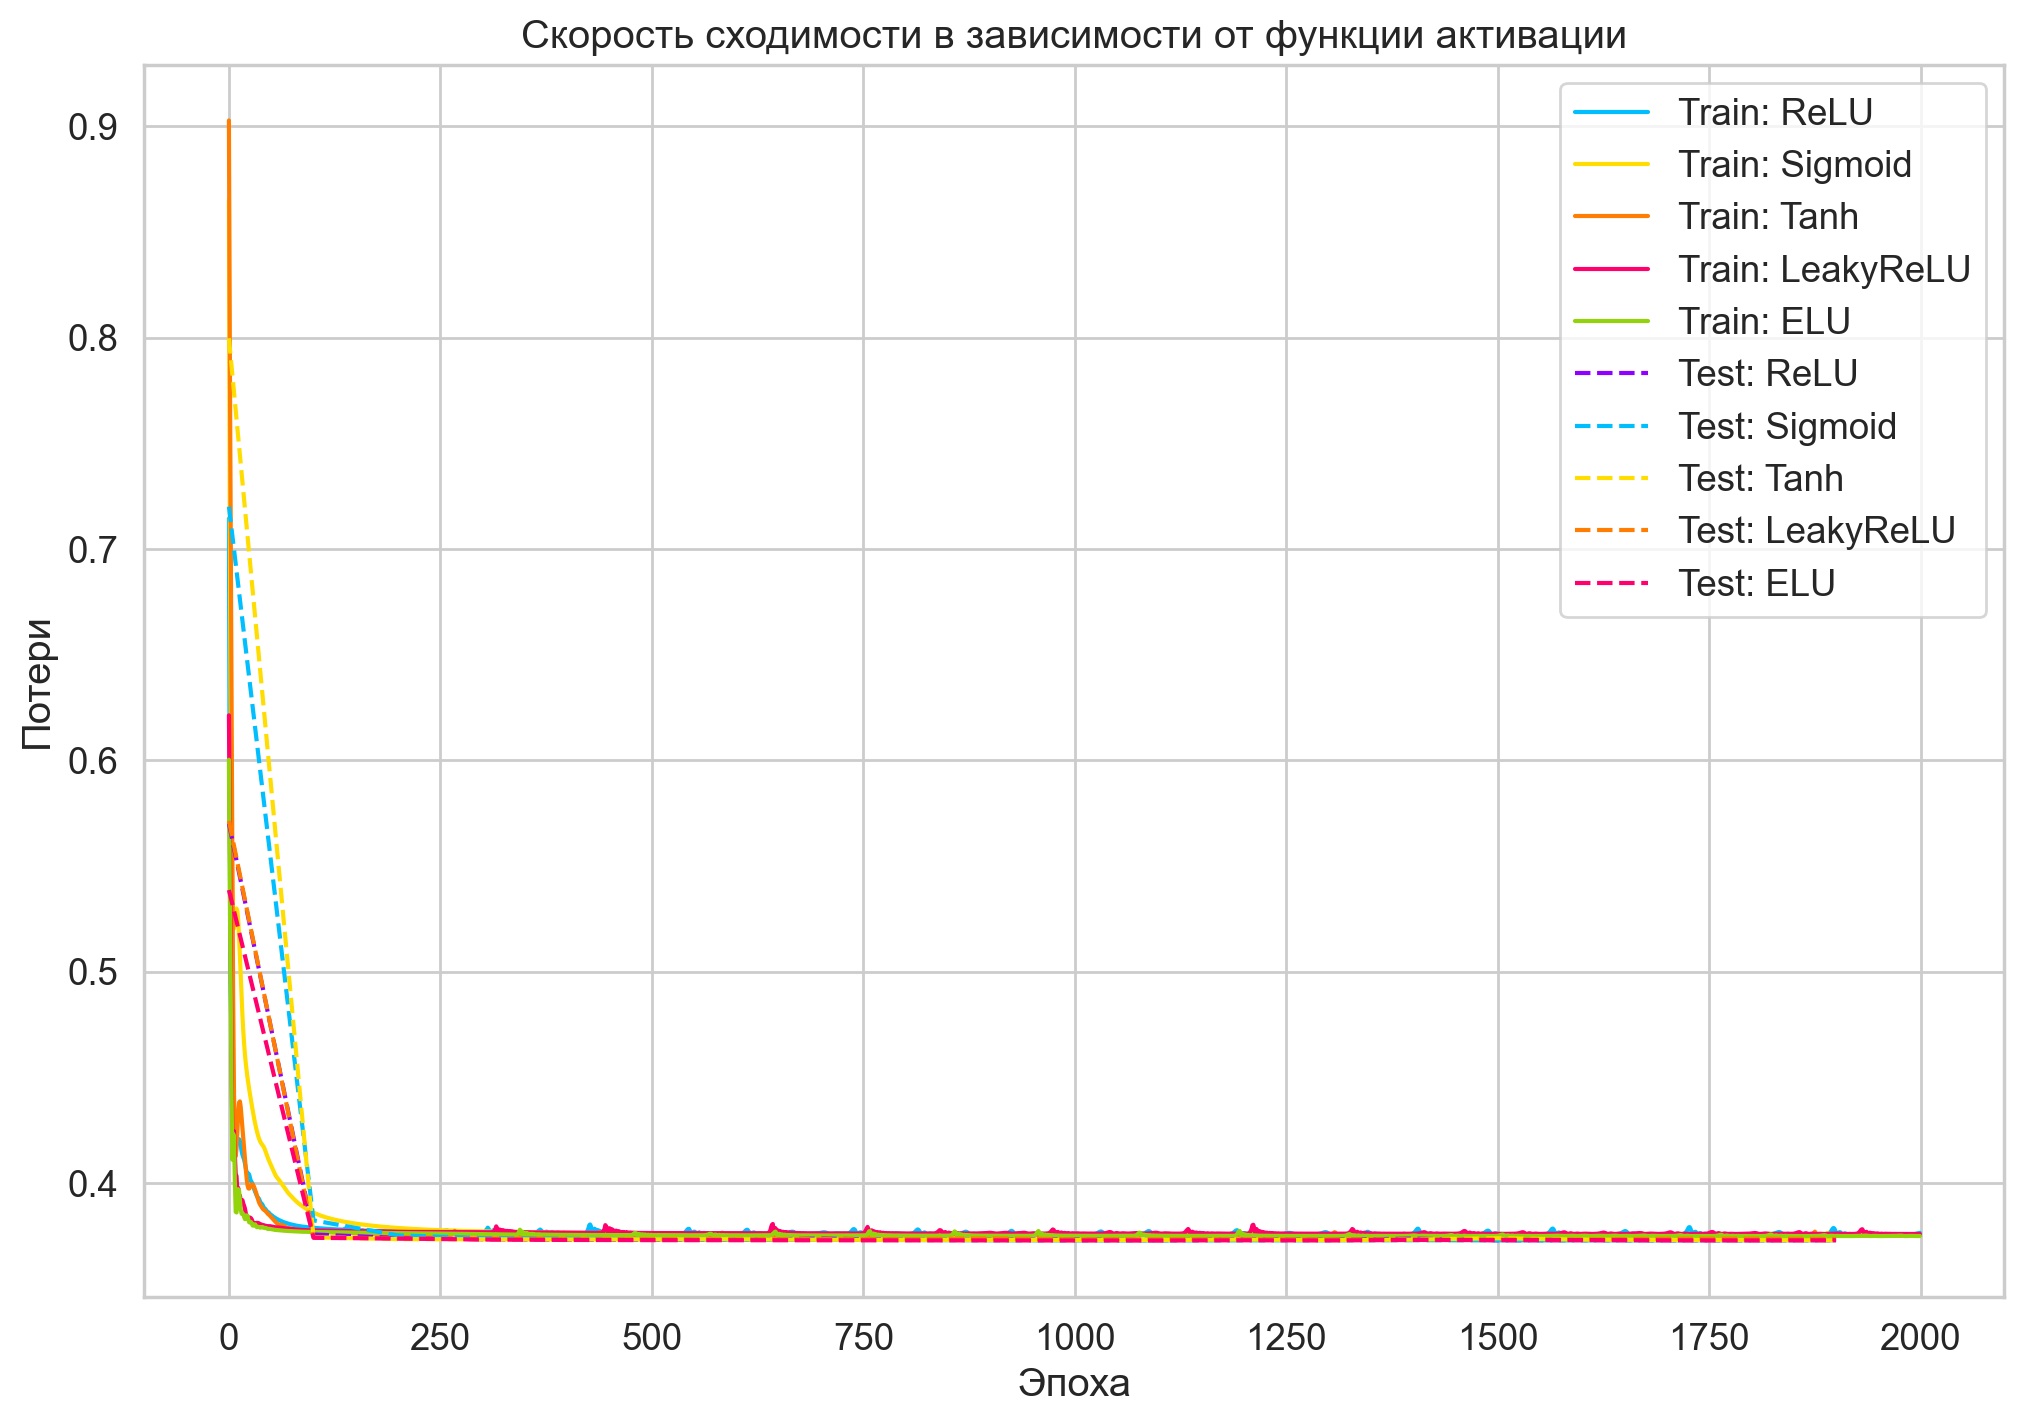

Функция активации: ReLU -> Лучшее значение test_loss: 0.37290340662002563
Функция активации: Sigmoid -> Лучшее значение test_loss: 0.3728547692298889
Функция активации: Tanh -> Лучшее значение test_loss: 0.372920423746109
Функция активации: LeakyReLU -> Лучшее значение test_loss: 0.37326887249946594
Функция активации: ELU -> Лучшее значение test_loss: 0.37281686067581177


In [63]:
train_loss = {}
test_loss = {}

for activation_name, activation_fn in activation_functions.items():
    print(f'Обучение с функцией активации: {activation_name}')
    train_losses, test_losses = train_and_evaluate_with_activation(activation_fn)
    train_loss[activation_name] = train_losses
    test_loss[activation_name] = test_losses

for activation_name, losses in train_loss.items():
    plt.plot(losses, label=f'Train: {activation_name}')

for activation_name, losses in test_loss.items():
    plt.plot(range(0, 2000, 100), losses, label=f'Test: {activation_name}', linestyle='--')

plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Скорость сходимости в зависимости от функции активации')
plt.legend()
plt.show()

for activation_name in activation_functions:
    best_test_loss = min(test_loss[activation_name])
    print(f"Функция активации: {activation_name} -> Лучшее значение test_loss: {best_test_loss}")

### 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации. 
 https://pytorch.org/docs/stable/optim.html

In [69]:
class MyNet(nn.Module):
    def __init__(self, n_features, activation_fn):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(n_features, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

def train_and_evaluate_with_activation_optim(optimizer_name, activation_fn):
    net = MyNet(4, activation_fn)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.1)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()

        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

            print(test_loss.item())

    return train_losses, test_losses

Обучение с методом оптимизации: SGD
0.5827980637550354
0.374828040599823
0.373941034078598
0.3739013075828552
0.3737553060054779
0.37340062856674194
0.3732674717903137
0.3727790117263794
0.37287437915802
0.37305259704589844
0.37283486127853394
0.3729119598865509
0.37283849716186523
0.3727526366710663
0.3727644085884094
0.37286174297332764
0.3727344572544098
0.3729110658168793
0.37294501066207886
0.37275129556655884
Обучение с методом оптимизации: Adam
0.55762779712677
0.3748762905597687
0.3742828369140625
0.3739107847213745
0.37358367443084717
0.3734232783317566
0.37336164712905884
0.37334373593330383
0.37323859333992004
0.37321341037750244
0.3734791874885559
0.3731977939605713
0.37315040826797485
0.3731517195701599
0.373578280210495
0.37298038601875305
0.37382301688194275
0.3729712665081024
0.3730008602142334
0.37309300899505615
Обучение с методом оптимизации: RMSprop
0.7018613815307617
0.37476974725723267
0.37444421648979187
0.37434449791908264
0.3739703297615051
0.3736397922039032
0

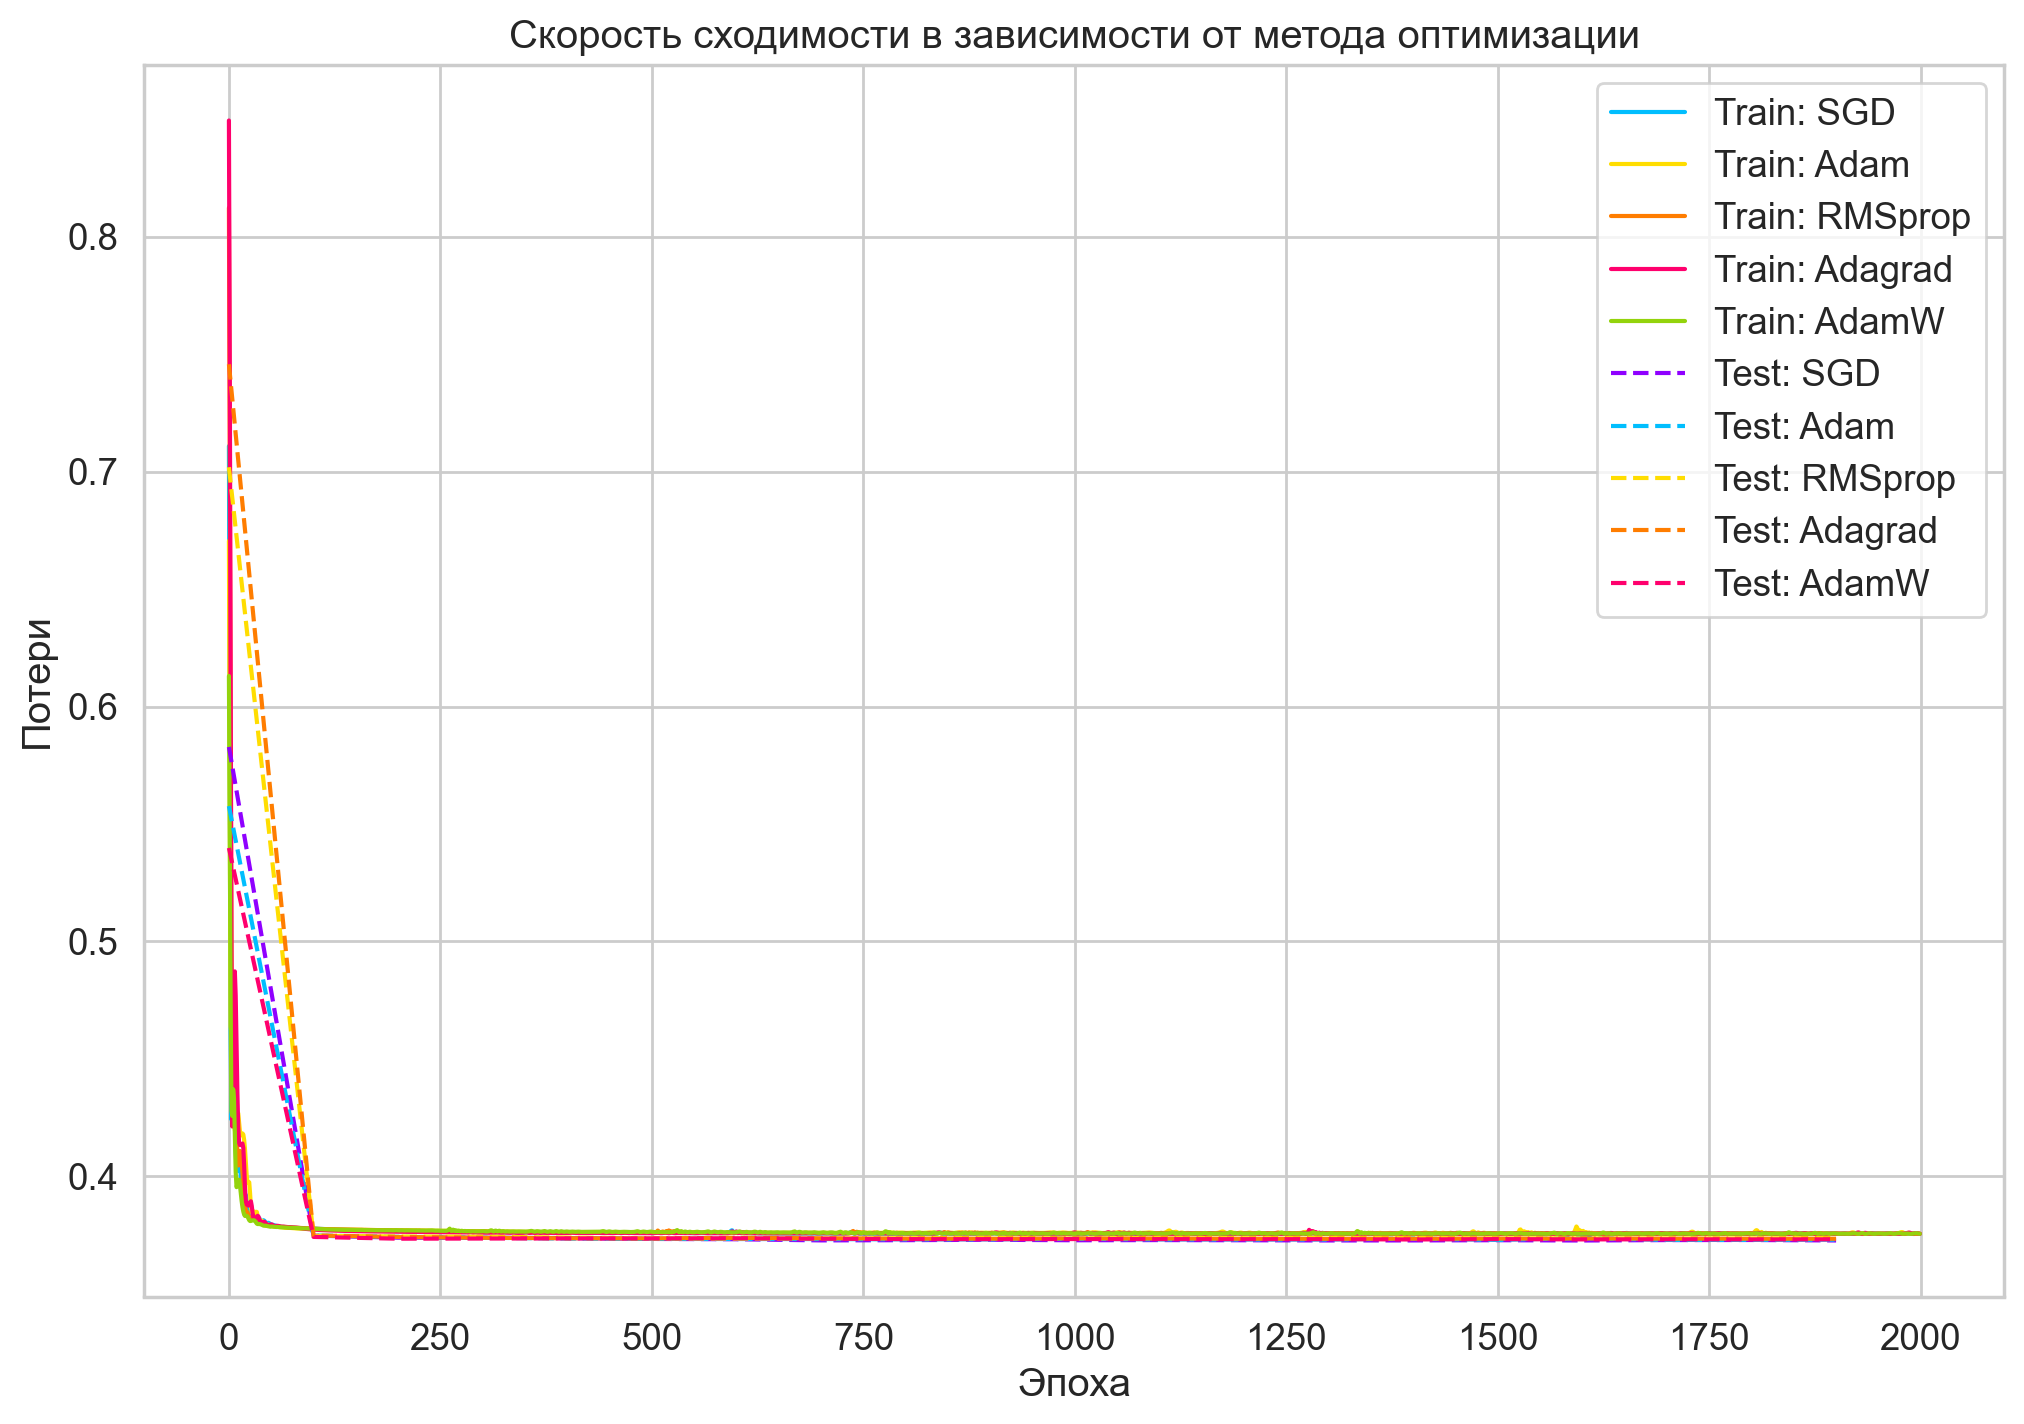

In [75]:
train_loss = {}
test_loss = {}

optimizers = ['SGD', 'Adam', 'RMSprop', 'Adagrad', 'AdamW']

for optimizer_name in optimizers:
    print(f'Обучение с методом оптимизации: {optimizer_name}')
    train_losses, test_losses = train_and_evaluate_with_activation_optim(optimizer_name, nn.LeakyReLU())
    train_loss[optimizer_name] = train_losses
    test_loss[optimizer_name] = test_losses

for optimizer_name, losses in train_loss.items():
    plt.plot(losses, label=f'Train: {optimizer_name}')

for optimizer_name, losses in test_loss.items():
    plt.plot(range(0, 2000, 100), losses, label=f'Test: {optimizer_name}', linestyle='--')

plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Скорость сходимости в зависимости от метода оптимизации')
plt.legend()
plt.show()

In [82]:
for optimizer_name in optimizers:
    best_test_loss = min(test_loss[optimizer_name])
    print(f"Метод оптимизации: {optimizer_name} -> Лучшее значение test_loss: {best_test_loss}")

Метод оптимизации: SGD -> Лучшее значение test_loss: 0.3727344572544098
Метод оптимизации: Adam -> Лучшее значение test_loss: 0.3729712665081024
Метод оптимизации: RMSprop -> Лучшее значение test_loss: 0.37352651357650757
Метод оптимизации: Adagrad -> Лучшее значение test_loss: 0.3734632134437561
Метод оптимизации: AdamW -> Лучшее значение test_loss: 0.3731737434864044


### 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [88]:
def initialize_weights(model, init_type):
    if init_type == 'default':
        pass
    elif init_type == 'xavier':
        for layer in model.children():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    elif init_type == 'he':
        for layer in model.children():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
    elif init_type == 'normal':
        for layer in model.children():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.01)
                nn.init.zeros_(layer.bias)
    elif init_type == 'uniform':
        for layer in model.children():
            if isinstance(layer, nn.Linear):
                nn.init.uniform_(layer.weight, a=-0.1, b=0.1)
                nn.init.zeros_(layer.bias)

def train_and_evaluate_with_weight_init(init_type):
    net = MyNet(4, nn.Sigmoid())
    initialize_weights(net, init_type)
    criterion = nn.BCELoss()
    optimizer = optim.Adagrad(net.parameters(), lr=0.1)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()

        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses


Обучение с инициализацией весов: random
Обучение с инициализацией весов: xavier
Обучение с инициализацией весов: he
Обучение с инициализацией весов: zero


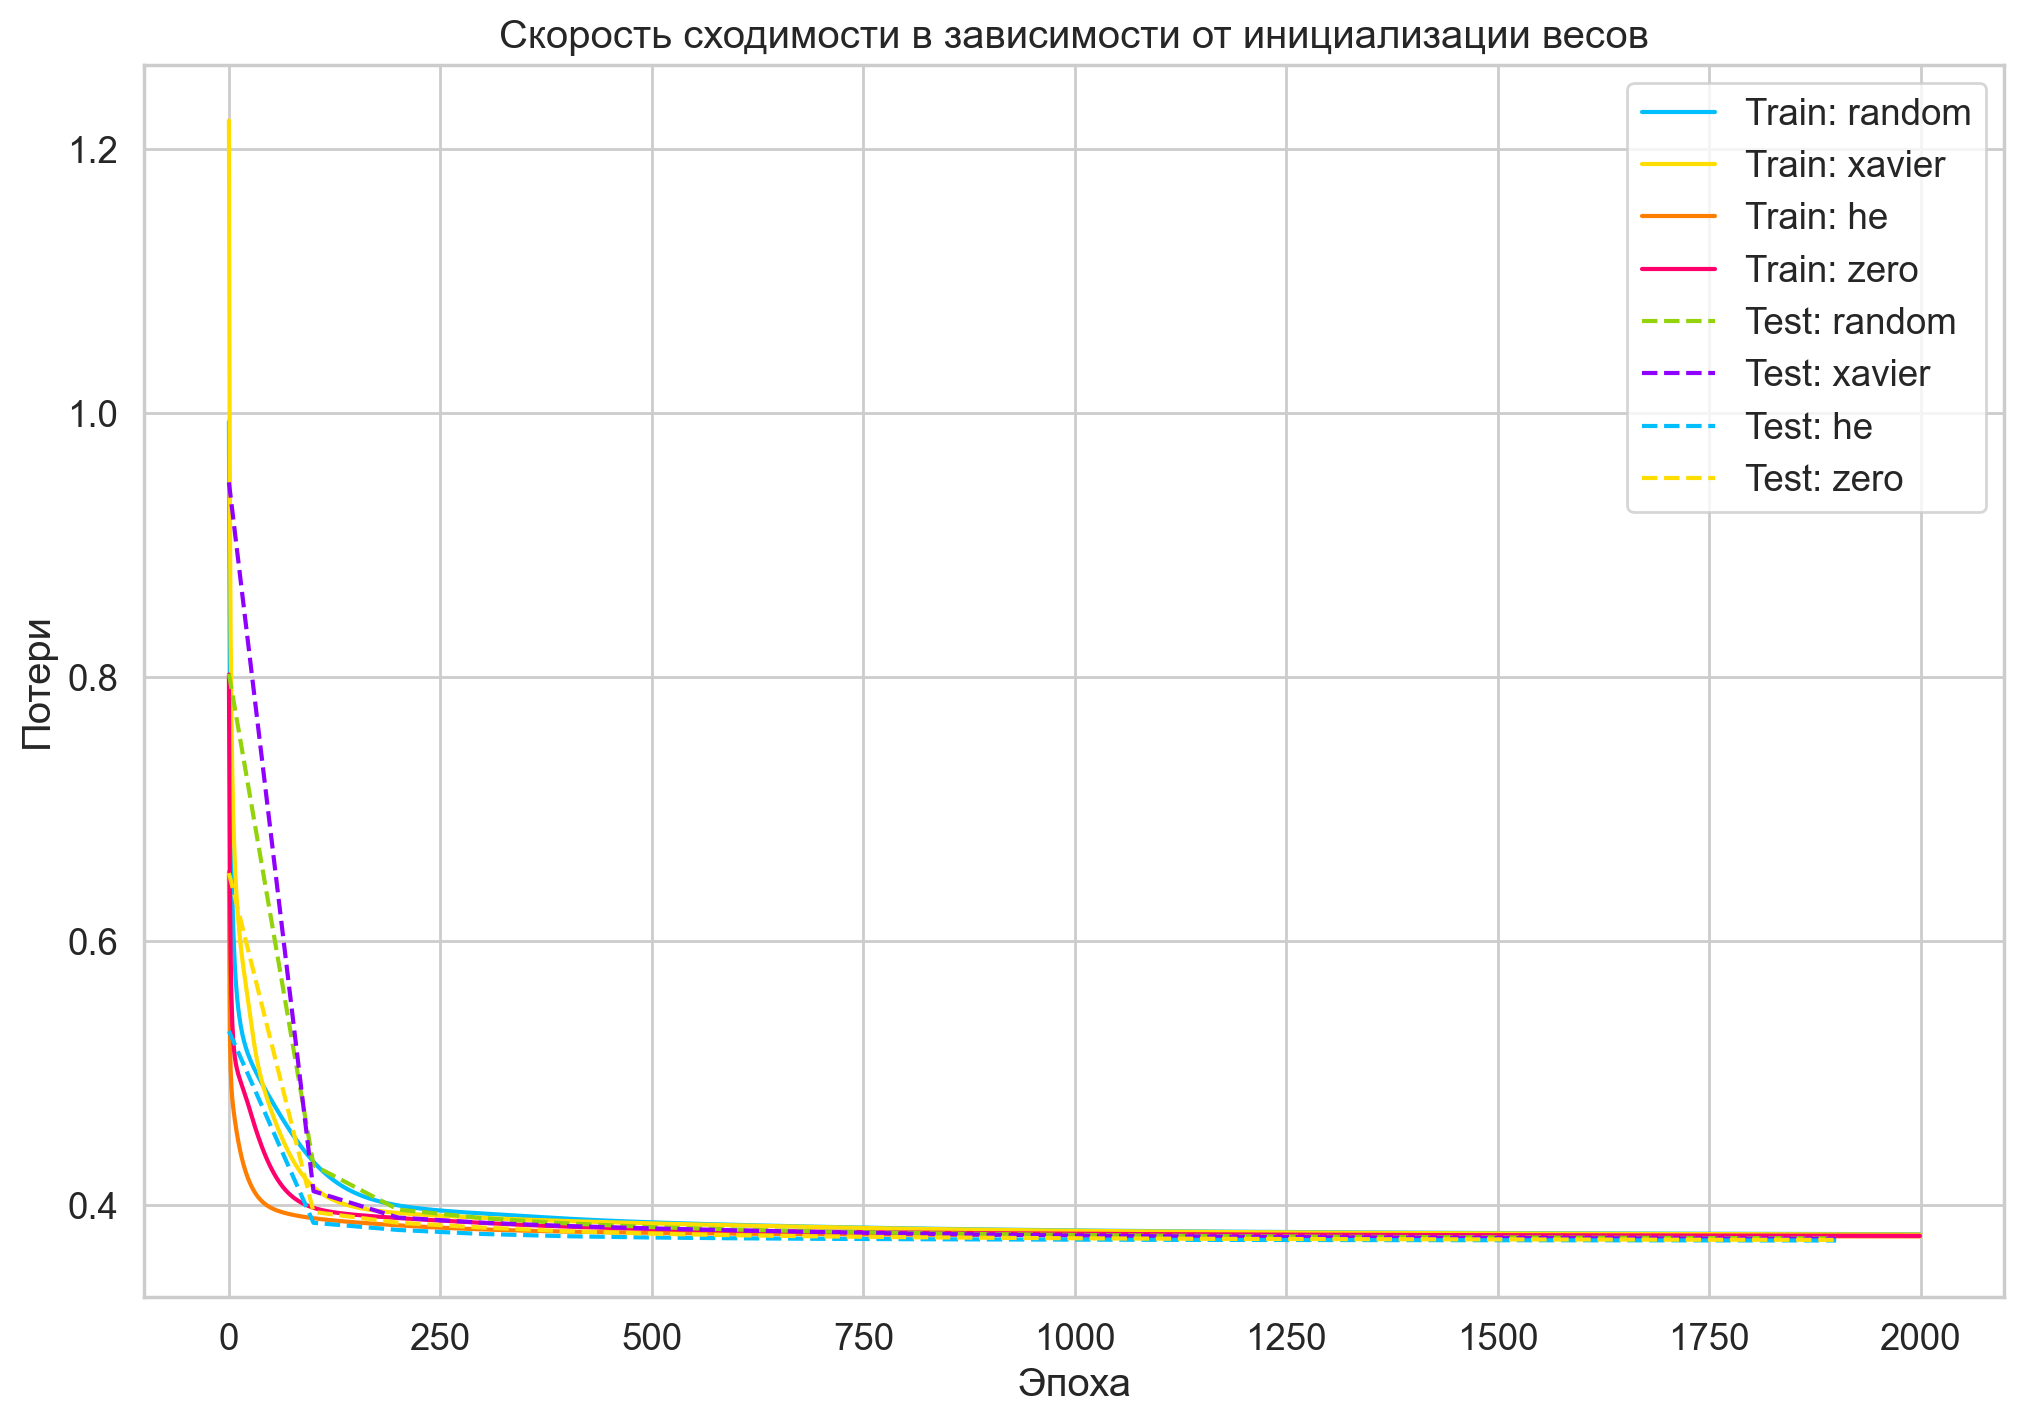

In [95]:
train_loss = {}
test_loss = {}

initializations = ['random', 'xavier', 'he', 'zero']

for init_type in initializations:
    print(f'Обучение с инициализацией весов: {init_type}')
    train_losses, test_losses = train_and_evaluate_with_weight_init(init_type)
    train_loss[init_type] = train_losses
    test_loss[init_type] = test_losses

for init_type, losses in train_loss.items():
    plt.plot(losses, label=f'Train: {init_type}')

for init_type, losses in test_loss.items():
    plt.plot(range(0, 2000, 100), losses, label=f'Test: {init_type}', linestyle='--')

plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Скорость сходимости в зависимости от инициализации весов')
plt.legend()
plt.show()

In [100]:
for init_type in initializations:
    best_test_loss = min(test_loss[init_type])
    print(f"Метод инициализации: {init_type} -> Лучшее значение test_loss: {best_test_loss}")

Метод инициализации: random -> Лучшее значение test_loss: 0.3748836815357208
Метод инициализации: xavier -> Лучшее значение test_loss: 0.37454313039779663
Метод инициализации: he -> Лучшее значение test_loss: 0.37323635816574097
Метод инициализации: zero -> Лучшее значение test_loss: 0.3737354576587677
